In [3]:
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, KITTI_Object, draw_2Dbox
from util_kitti import draw_corner_2D, draw_birdeyes, set_bev_background, init_img_plt, load_tf_image

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2
import pprint

ANCHOR_NAME = 'anchors_fpn_fuse_16' # anchors_fpn_full_feature

INPUT_SHAPE = (384, 1280)
PYRIMID_LEVEL = [3, 4, 5, 6, 7]

# SHOW_COOR = (15, 60)
# LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"


[58, 62, 66, 70, 74, 78]
[38, 41, 44, 47, 50, 53, 56, 59, 62, 65]
[25, 27, 29, 31, 33, 35, 37]
[10, 12, 14, 16, 18, 20, 22, 24]
[3, 4, 5, 6, 7, 8, 9]
Level_3 cx_offset_list = [4]
Level_3 cy_offset_list = [4]
anchor_count = 4800 at level 3
For pyrimid level_3
{58: [21, 22, 23, 24, 25],
 62: [21, 22, 23, 24, 25],
 66: [21, 22, 23, 24, 25],
 70: [21, 22, 23, 24, 25],
 74: [21, 22, 23, 24, 25],
 78: [21, 22, 23, 24, 25]}
None
Level_4 cx_offset_list = [8]
Level_4 cy_offset_list = [8]
anchor_count = 3200 at level 4
For pyrimid level_4
{38: [10, 11, 12, 13],
 41: [10, 11, 12, 13],
 44: [10, 11, 12, 13],
 47: [10, 11, 12, 13],
 50: [10, 11, 12, 13],
 53: [10, 11, 12, 13],
 56: [10, 11, 12, 13],
 59: [10, 11, 12, 13],
 62: [10, 11, 12, 13],
 65: [10, 11, 12, 13]}
None
Level_5 cx_offset_list = [8, 24]
Level_5 cy_offset_list = [8, 24]
anchor_count = 3360 at level 5
For pyrimid level_5
{25: [5, 6, 7],
 27: [5, 6, 7],
 29: [5, 6, 7],
 31: [5, 6, 7],
 33: [5, 6, 7],
 35: [5, 6, 7],
 37: [5, 6, 7]}
N

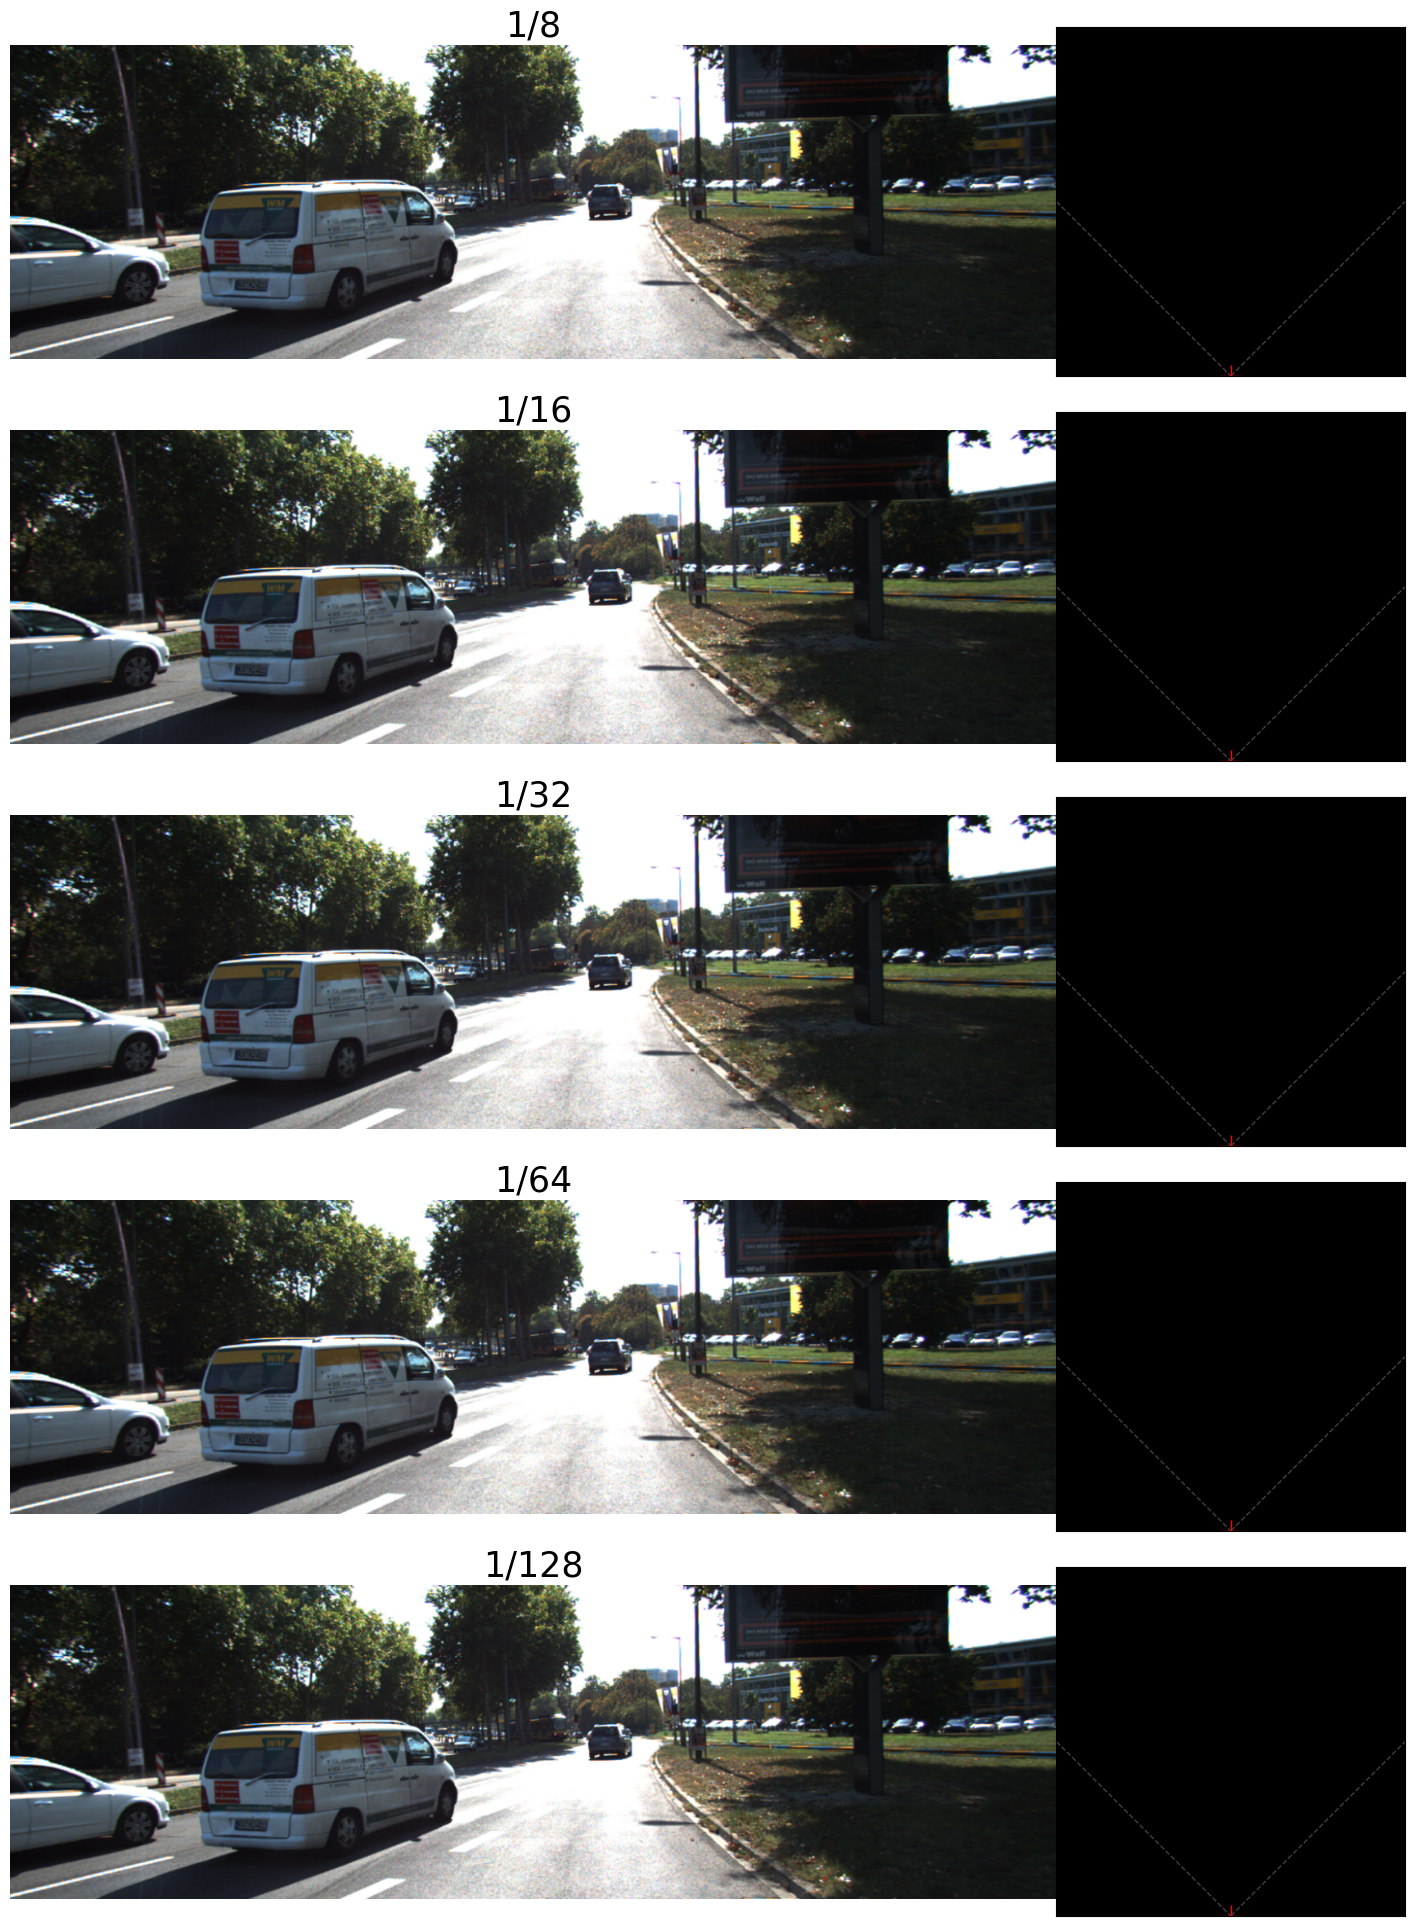

In [8]:
# %%script false --no-raise-error
# anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, 
#                         a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
#                         a.x3d, a.y3d, a.z3d, a.rot_y])

img = cv2.imread("/home/lab530/KenYu/kitti/training/image_2/000296.png") # 'A' type image
P2  = kitti_calib_file_parser("/home/lab530/KenYu/kitti/training/calib/000169.txt")
img_ori_h, img_ori_w, _ = img.shape
# Resize 
P2[0, :] *= INPUT_SHAPE[1]  / img_ori_w
P2[1, :] *= INPUT_SHAPE[0]  / img_ori_h

img = cv2.resize(img, (INPUT_SHAPE[1], INPUT_SHAPE[0]))

axs = init_img_plt([img]*5, titles = [f"1/{2**i}" for i in PYRIMID_LEVEL])

# cz_range = {3: [70, 60, 50],
#           4: [50, 40 ,30],
#           5: [30, 25 ,20],
#           6: [20, 15 ,10],
#           7: [10, 5  ,3 ]}

# cz_range = {3: [80],
#           4: [40],
#           5: [30],
#           6: [15],
#           7: [5]}

# cz_range = {3: list(range(0, 81, 1)),
#           4: list(range(0, 81, 1)),
#           5: list(range(0, 81, 1)),
#           6: list(range(0, 81, 1)),
#           7: list(range(0, 81, 1))}

# cz_range = {3: list(range(60, 81, 5)),
#           4: list(range(40, 70, 3)),
#           5: list(range(30, 40, 2)),
#           6: list(range(15, 30, 2)),
#           7: list(range(0,  15, 2))}


cz_range = {3: list(range(58, 79, 4)), # [58, 78] -> [21, 22, 23, 24, 25]
          4: list(range(38, 67, 3)), # [38, 66] -> [10, 11, 12, 13]
          5: list(range(25, 38, 2)), # [25, 37] -> [5, 6]
          6: list(range(10, 25, 2)), # [10, 37] -> [3]
          7: list(range(3,  10, 1))} # [0, 16]   -> [1, 2]

# For anchor_fpn
y_f_idx_range = {3: [21, 22, 23, 24, 25],
                 4: [10, 11, 12, 13],
                 5: [5, 6, 7],
                 6: [3, 4],
                 7: [2]}
# y_f_idx_range = {3: list(range(48)),
#                  4: list(range(24)),
#                  5: list(range(12)),
#                  6: list(range(6)),
#                  7: list(range(3))}

# anchor_count for every pixel in different level 
# anchor_fpn:
    # anchor_count = 6 at level 3
    # anchor_count = 10 at level 4
    # anchor_count = 28 at level 5
    # anchor_count = 128 at level 6
    # anchor_count = 448 at level 7
# Anchor_fpn_fuse_16:
    # anchor_count = 6 at level 3
    # anchor_count = 10 at level 4
    # anchor_count = 7 at level 5
    # anchor_count = 8 at level 6
    # anchor_count = 7 at level 7


## Curve Fitting
def func(x, a, b, c, d, e ,f):
    return a*(x**5) + b*(x**4) + c*(x**3) + d*(x**2) + e*(x**1) + f
popt_upper = [-1.90815087e-09, 5.38463353e-07, -5.53958419e-05, 2.20737910e-03, 1.49866278e-04, 2.03962338e+00]
popt_lower = [ 1.90813996e-09,-5.38460756e-07,  5.53956217e-05,-2.20737124e-03,-1.49969144e-04, 1.40410610e+00]

anchors_dict = {3: [],
                4: [],
                5: [],
                6: [],
                7: []}

anchors_tensor = []

for pyrimid_level in PYRIMID_LEVEL:
    
    d_ratio = 2**pyrimid_level
    feat_map_h = int( INPUT_SHAPE[0] / d_ratio )
    feat_map_w = int( INPUT_SHAPE[1] / d_ratio )
    
    # Get Offset
    if d_ratio == 8:
        cx_offset_list = [4]
        cy_offset_list = [4]
    else:
        cx_offset_list = list(range(8, d_ratio, 16))
        cy_offset_list = list(range(8, d_ratio, 16))

    print(f"Level_{pyrimid_level} cx_offset_list = {cx_offset_list}")
    print(f"Level_{pyrimid_level} cy_offset_list = {cy_offset_list}")
    
    pass_dict = {}
    for cz in cz_range[pyrimid_level]:
        pass_dict[cz] = []
    
    anchor_count = 0
    for y_f_idx in y_f_idx_range[pyrimid_level]:
        for cy_offset in cy_offset_list:
            cy = y_f_idx * d_ratio + cy_offset
        
            for x_f_idx in range(feat_map_w):
                for cx_offset in cx_offset_list:
                    cx = x_f_idx * d_ratio + cx_offset

                    # print(f"(cx, cy) = {(cx, cy)}")
                    for cz in cz_range[pyrimid_level]:
                        
                        # Convert cx,cy,cz to x3d,y3d,z3d
                        loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
                        loc_3d[1, 0] += AVG_HEIGT / 2.0 
                        
                        # Filter unreasonable y_3d 
                        # if not (func(cz, *popt_lower) < loc_3d[1, 0] < func(cz, *popt_upper)): continue
                        
                        if y_f_idx not in pass_dict[cz]: pass_dict[cz].append(y_f_idx)
                        
                        # TODO, for rot_y in [0, pi/2]:
                        rot_y = pi/2
                        str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA"
                        # a = KITTI_Object(str_line, is_transform = False, center_2d = (cx,cy,cz)) # TODO center_2d is problemetic
                        a = KITTI_Object(str_line, tf_matrix = P2)
                        # 
                        anchors_tensor.append(np.array([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y]))
                        
                        # anchors.append(a)
                        anchors_dict[pyrimid_level].append(a)
                        
                        anchor_count += 1
    print(f"anchor_count = {anchor_count} at level {pyrimid_level}")

    print(f"For pyrimid level_{pyrimid_level}")
    print(pprint.pprint(pass_dict))

anchors_tensor = np.array(anchors_tensor)
anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]

# Draw anchors
# for i_level, pyrimid_level in enumerate(PYRIMID_LEVEL):
#     print(f"level_{i_level} has {len(anchors_dict[pyrimid_level])} anchors") # , and every pixel has {} anchors")
#     sum_area = 0
#     for a in anchors_dict[pyrimid_level]:
#         rnd_color = (random.random(), random.random(), random.random())
#         # draw_corner_2D(axs[i_level][0], a.corner_2D, color = rnd_color, is_draw_front = False)
#         draw_2Dbox    (axs[i_level][0], (a.xmin, a.ymin, a.xmax, a.ymax), color = rnd_color)
#         draw_birdeyes (axs[i_level][1], a, color = rnd_color)
#         sum_area += a.area
#     print(f"level_{i_level} has average area of {sum_area / len(anchors_dict[pyrimid_level])}")

print(f"Total Number of anchor = {anchors_tensor.shape[0]}")

# Show anchor on single pixel

level_0 has 4800 anchors
level_1 has 3200 anchors
level_2 has 3360 anchors
level_3 has 5120 anchors
level_4 has 4480 anchors


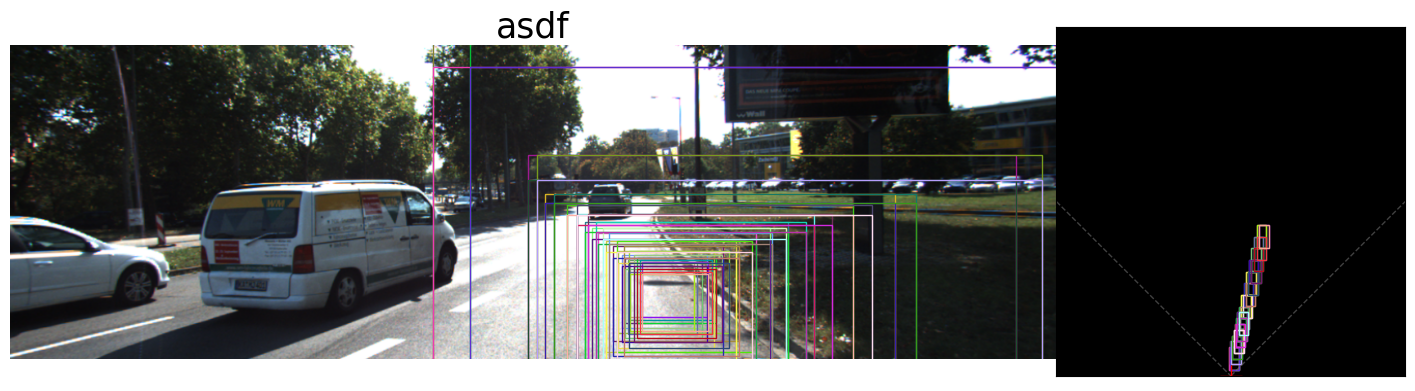

In [5]:
SHOW_COOR = (300, 800) # (384, 1280)
axs = init_img_plt([img], titles = ["asdf"])

for i_level, pyrimid_level in enumerate(PYRIMID_LEVEL):
    print(f"level_{i_level} has {len(anchors_dict[pyrimid_level])} anchors")
    for a in anchors_dict[pyrimid_level]:
        if abs(a.cx - SHOW_COOR[1]) < 16 and abs(a.cy - SHOW_COOR[0]) < 16:
            rnd_color = (random.random(), random.random(), random.random())

            draw_2Dbox    (axs[0][0], (a.xmin, a.ymin, a.xmax, a.ymax), color = rnd_color)
            draw_birdeyes (axs[0][1], a, color = rnd_color)



# Output anchor_fpn

In [6]:
with open(f"pkl/{ANCHOR_NAME}.pkl", 'wb') as f:
    pickle.dump(anchors_tensor, f)
print(f"Write anchor result to {ANCHOR_NAME}.pkl")


# For 2D detector
with open(f"pkl/{ANCHOR_NAME}_2D.pkl", 'wb') as f:
    pickle.dump(anchors_tensor[:, :4], f)
    # print(anchors_tensor[:, :4].shape) # torch.Size([20960, 4])
print(f"Write anchor result to {ANCHOR_NAME}_2D.pkl")

# # Get anchor_map
# heat_data = np.zeros(shape=(18, 80))
# for a in anchors_tensor:
#     heat_data[int(a[6]/16), int(a[5]/16)] += 1
# max_n_anchor = int(heat_data.max())
# anchor_map = []
# for i in range(18):
#     for j in range(80):
#         anchor_map += ( [True for _ in range(int(heat_data[i, j]))] + [False for _ in range(max_n_anchor - int(heat_data[i, j]))] )
# anchor_map = torch.tensor(anchor_map)


# print( f"Total number of anchor = {anchor_map.shape}" ) # [46080] trues
# print( f"Number of useful anchor = {torch.count_nonzero(anchor_map)}" )

# with open(f"pkl/{ANCHOR_NAME}_map.pkl", 'wb') as f:
#     pickle.dump(anchor_map, f)
# print(f"Write anchor result to {ANCHOR_NAME}_map.pkl")

Write anchor result to anchors_fpn_fuse_16.pkl
Write anchor result to anchors_fpn_fuse_16_2D.pkl
